## Instalação das bibliotecas necessárias

In [1]:
%pip install pandas numpy scikit-learn xgboost matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Importações

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import time


## Dados

### Carregamento dos dados

In [3]:
df = pd.read_parquet('data/train.parquet')
test = pd.read_parquet('data/test.parquet')

In [4]:
print("Informações do Dataset:")
print(df.info())

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152038 entries, 0 to 152037
Data columns (total 62 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      151333 non-null  float64
 1   x1      152037 non-null  float64
 2   x2      152037 non-null  float64
 3   x3      71762 non-null   float64
 4   x4      152037 non-null  float64
 5   x5      152037 non-null  float64
 6   x6      146648 non-null  float64
 7   x7      152037 non-null  float64
 8   x8      149891 non-null  float64
 9   x9      147583 non-null  float64
 10  x10     151937 non-null  float64
 11  x11     71762 non-null   float64
 12  x12     151333 non-null  float64
 13  x13     151937 non-null  float64
 14  x14     152037 non-null  float64
 15  x15     149943 non-null  float64
 16  x16     71762 non-null   float64
 17  x17     152037 non-null  float64
 18  x18     146412 non-null  float64
 19  x19     151333 non-null  float64
 20  x20     151876 non-null 

### Análise de correlação

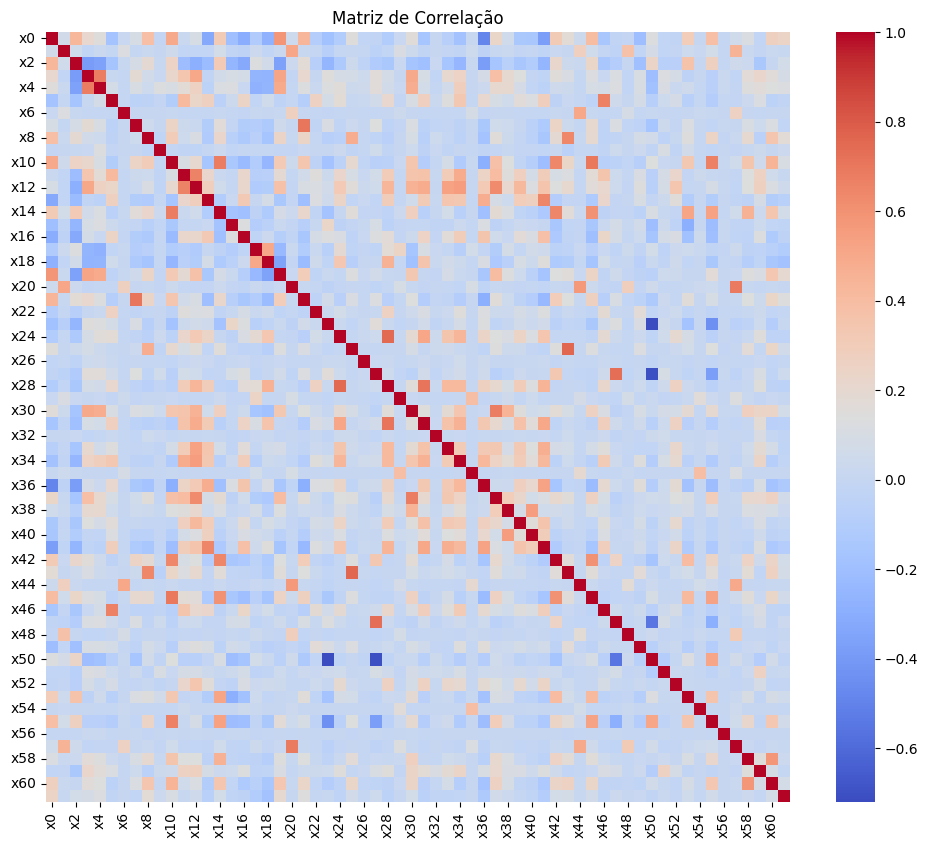

In [5]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


## PCA

In [ ]:
# Importando as bibliotecas necessárias
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Preparando os dados para PCA
X = df.drop('y', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Realizando PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculando a variância explicada acumulada
variancia_explicada_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Plotando a variância explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(variancia_explicada_acumulada) + 1), variancia_explicada_acumulada, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente Principal')
plt.grid(True)
plt.show()

# Determinando o número de componentes para explicar 95% da variância
n_componentes = np.argmax(variancia_explicada_acumulada >= 0.95) + 1
print(f"Número de componentes para explicar 95% da variância: {n_componentes}")

# Realizando PCA com o número de componentes selecionado
pca_final = PCA(n_components=n_componentes)
X_pca_final = pca_final.fit_transform(X_scaled)

# Plotando as duas primeiras componentes principais
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_final[:, 0], X_pca_final[:, 1], c=df['y'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.xlabel('Primeira Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.title('Visualização das Duas Primeiras Componentes Principais')
plt.show()

# Analisando a contribuição das features originais para as componentes principais
componentes_principais = pd.DataFrame(
    pca_final.components_.T,
    columns=[f'PC{i+1}' for i in range(n_componentes)],
    index=X.columns
)

plt.figure(figsize=(12, 8))
sns.heatmap(componentes_principais, cmap='coolwarm', annot=False)
plt.title('Contribuição das Features para as Componentes Principais')
plt.show()

print("Análise PCA concluída.")


### Divisão dos Dados

In [ ]:
# Divisão dos dados utilizando os dados gerados com PCA

X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca_final, df['y'], test_size=0.2, stratify=df['y'], random_state=42)

print("Dimensões dos conjuntos de dados:")
print(f"X_pca_train: {X_pca_train.shape}")
print(f"X_pca_test: {X_pca_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


In [6]:
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## Função para avaliar o modelo


In [7]:
def avaliar_modelo(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Matriz de Confusão')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Previsto')
    plt.show()
    
    y_prob = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

## Modelos

### Random Forest


#### Treinamento

In [8]:
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

#### Melhores parâmetros


Melhores parâmetros para Random Forest:
{'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Avaliação do Random Forest:
Acurácia: 0.8705
Precisão: 0.8777
Recall: 0.9861
F1-Score: 0.9288


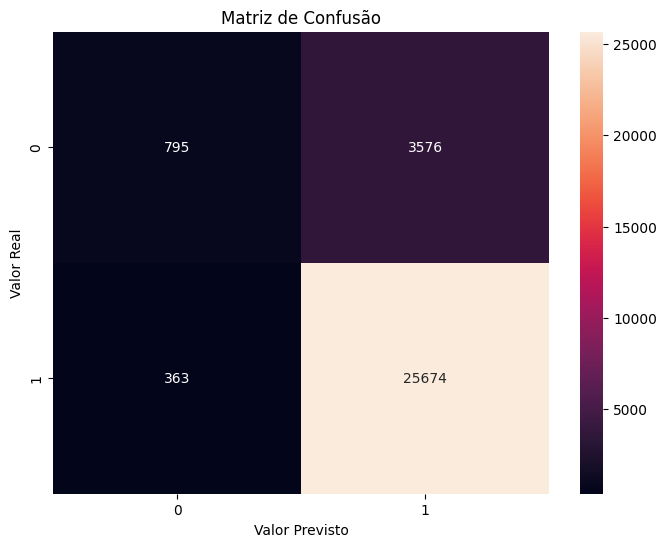

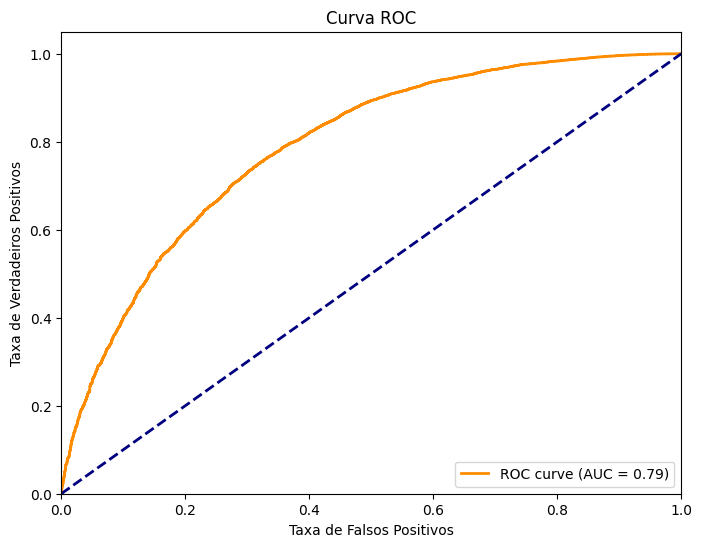

In [9]:
print("Melhores parâmetros para Random Forest:")
print(grid_search_rf.best_params_)

rf_best = grid_search_rf.best_estimator_
print("\nAvaliação do Random Forest:")
avaliar_modelo(rf_best, X_test, y_test)

### Importância das variáveis para Random Forest

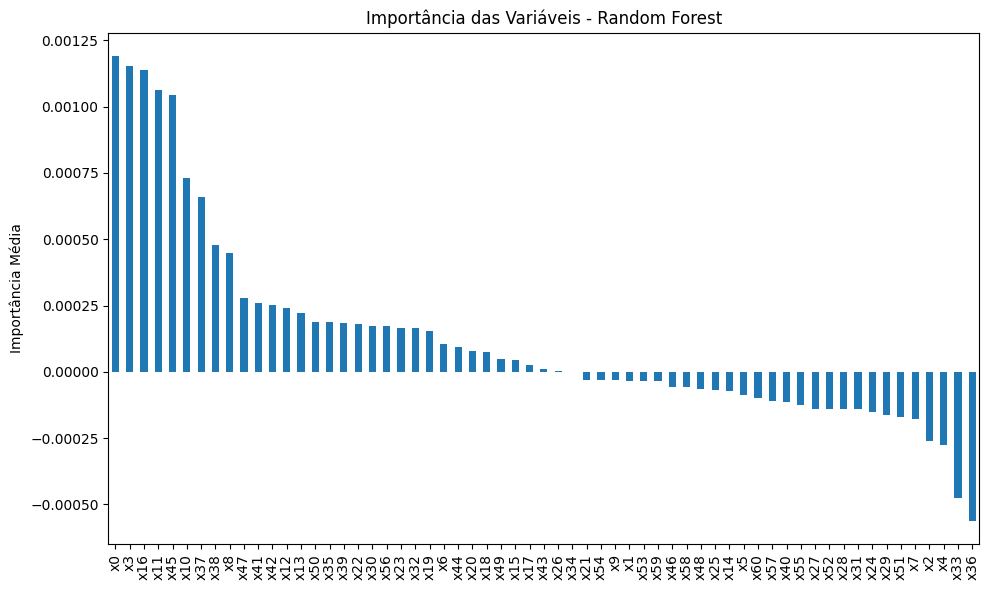

In [10]:
importances = permutation_importance(rf_best, X_test, y_test, n_repeats=10, random_state=42)
forest_importances = pd.Series(importances.importances_mean, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
forest_importances.plot.bar()
plt.title("Importância das Variáveis - Random Forest")
plt.ylabel("Importância Média")
plt.tight_layout()
plt.show()

### XGBoost


#### Treinamento

In [11]:
xgb = XGBClassifier(random_state=42)
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             verbose=1)

#### Melhores parâmetros



Melhores parâmetros para XGBoost:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}

Avaliação do XGBoost:
Acurácia: 0.8713
Precisão: 0.8815
Recall: 0.9818
F1-Score: 0.9289


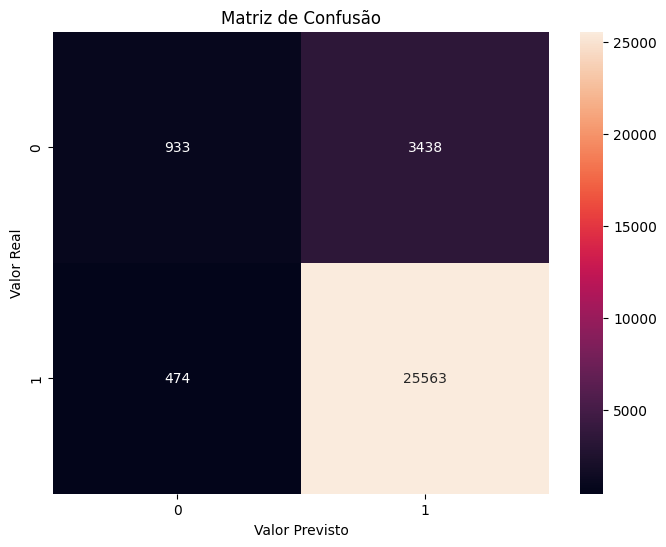

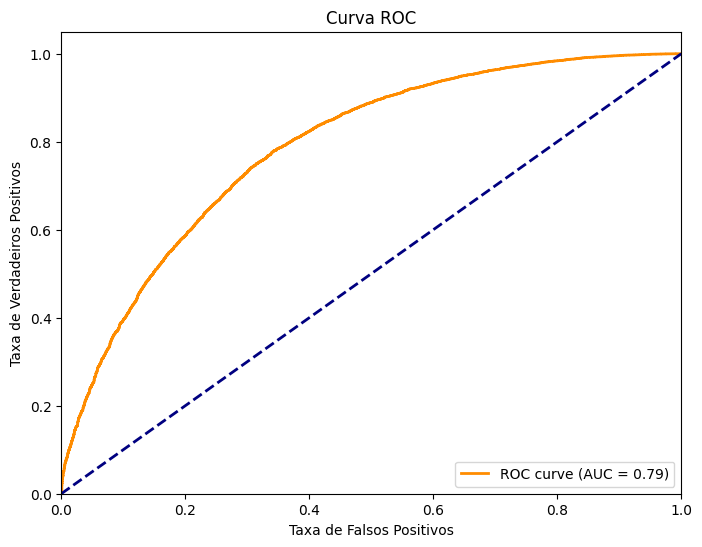

In [12]:
print("\nMelhores parâmetros para XGBoost:")
print(grid_search_xgb.best_params_)

xgb_best = grid_search_xgb.best_estimator_
print("\nAvaliação do XGBoost:")
avaliar_modelo(xgb_best, X_test, y_test)

## Comparação dos modelos

### Tempo de treinamento


In [13]:
start_time = time.time()
rf_best.fit(X_train, y_train)
rf_time = time.time() - start_time

start_time = time.time()
xgb_best.fit(X_train, y_train)
xgb_time = time.time() - start_time

print(f"\nTempo de treinamento do Random Forest: {rf_time:.2f} segundos")
print(f"Tempo de treinamento do XGBoost: {xgb_time:.2f} segundos")


Tempo de treinamento do Random Forest: 140.36 segundos
Tempo de treinamento do XGBoost: 2.85 segundos


## Conclusão
